In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
n=25000
n=4*(n//4)

mu11=5
mu12=12
mu1=[mu11,mu12]
sig11=50
sig12=70
cov1=[[sig11,0],[0,sig12]]
x1 = np.random.multivariate_normal(mu1,cov1,n//4)

mu21=60
mu22=100
mu2=[mu21,mu22]
sig21=30
sig22=15
cov2=[[sig21,0],[0,sig22]]
x2 = np.random.multivariate_normal(mu2,cov2,n//4)

mu31=-30
mu32=50
mu3=[mu31,mu32]
sig31=50
sig32=45
cov3=[[sig31,0],[0,sig32]]
x3 = np.random.multivariate_normal(mu3,cov3,n//4)

mu41=70
mu42=-50
mu4=[mu41,mu42]
sig41=45
sig42=75
cov4=[[sig41,0],[0,sig42]]
x4 = np.random.multivariate_normal(mu4,cov4,n//4)

mu51=-90
mu52=-20
mu5=[mu51,mu52]
sig51=30
sig52=60
cov5=[[sig51,0],[0,sig52]]
x5 = np.random.multivariate_normal(mu5,cov5,n//4)

x_n = np.concatenate((x1,x2,x5))
np.random.shuffle(x_n)

X=np.concatenate((x_n,x3,x4))
X = StandardScaler().fit_transform(X)

In [7]:

x_train = X[6250:]
x_test=X[:6250]
y_test=np.zeros(int((n//4)))

y_train = np.concatenate((np.zeros(int(n//2)),np.ones(int(n//4)),np.ones(n//4))).reshape(-1, 1).astype(int)
print(x_train)
print(y_train)

[[-0.11523526  0.05652988]
 [ 0.0613138   0.05266093]
 [ 0.0158782  -0.06064529]
 ...
 [ 1.05311895 -1.25671133]
 [ 1.08009906 -1.47972908]
 [ 1.05422248 -1.44950239]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [15]:
num_of_iterations = 5#Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(12500, 2)
Size: 10 Bits - FPR: 0.086400 - Time Taken to create Standard: 0.066767 - Time Taken to create Projecion: 6.079813 



Size: 20 Bits - FPR: 0.068320 - Time Taken to create Standard: 0.054560 - Time Taken to create Projecion: 7.419567 



Size: 30 Bits - FPR: 0.022080 - Time Taken to create Standard: 0.082914 - Time Taken to create Projecion: 7.792258 



Size: 40 Bits - FPR: 0.020160 - Time Taken to create Standard: 0.203008 - Time Taken to create Projecion: 4.548893 



Size: 50 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.052870 - Time Taken to create Projecion: 4.167582 



Size: 60 Bits - FPR: 0.012480 - Time Taken to create Standard: 0.053884 - Time Taken to create Projecion: 4.146381 



Size: 70 Bits - FPR: 0.007520 - Time Taken to create Standard: 0.054005 - Time Taken to create Projecion: 4.259748 



Size: 80 Bits - FPR: 0.010720 - Time Taken to create Standard: 0.052234 - Time Taken to create Projecion: 9.659329 



Size:

Size: 690 Bits - FPR: 0.003680 - Time Taken to create Standard: 0.193133 - Time Taken to create Projecion: 7.082314 



Size: 700 Bits - FPR: 0.003040 - Time Taken to create Standard: 0.065682 - Time Taken to create Projecion: 5.669991 



Size: 710 Bits - FPR: 0.003360 - Time Taken to create Standard: 0.065284 - Time Taken to create Projecion: 5.397607 



Size: 720 Bits - FPR: 0.003040 - Time Taken to create Standard: 0.113015 - Time Taken to create Projecion: 6.307610 



Size: 730 Bits - FPR: 0.002560 - Time Taken to create Standard: 0.054032 - Time Taken to create Projecion: 7.036821 



Size: 740 Bits - FPR: 0.002880 - Time Taken to create Standard: 0.056073 - Time Taken to create Projecion: 6.678908 



Size: 750 Bits - FPR: 0.002720 - Time Taken to create Standard: 0.108186 - Time Taken to create Projecion: 7.020951 



Size: 760 Bits - FPR: 0.002080 - Time Taken to create Standard: 0.074075 - Time Taken to create Projecion: 7.418157 



Size: 770 Bits - FPR: 0.003040 - Time Ta

Size: 1370 Bits - FPR: 0.001760 - Time Taken to create Standard: 0.054810 - Time Taken to create Projecion: 4.145153 



Size: 1380 Bits - FPR: 0.003040 - Time Taken to create Standard: 0.055281 - Time Taken to create Projecion: 4.234529 



Size: 1390 Bits - FPR: 0.001600 - Time Taken to create Standard: 0.052526 - Time Taken to create Projecion: 4.150307 



Size: 1400 Bits - FPR: 0.002080 - Time Taken to create Standard: 0.061911 - Time Taken to create Projecion: 4.358657 



Size: 1410 Bits - FPR: 0.001440 - Time Taken to create Standard: 0.062356 - Time Taken to create Projecion: 4.285809 



Size: 1420 Bits - FPR: 0.002720 - Time Taken to create Standard: 0.053696 - Time Taken to create Projecion: 4.128924 



Size: 1430 Bits - FPR: 0.001920 - Time Taken to create Standard: 0.052803 - Time Taken to create Projecion: 4.346022 



Size: 1440 Bits - FPR: 0.003360 - Time Taken to create Standard: 0.058139 - Time Taken to create Projecion: 4.136839 



Size: 1450 Bits - FPR: 0.001760 

Size: 2050 Bits - FPR: 0.001600 - Time Taken to create Standard: 0.355564 - Time Taken to create Projecion: 6.214801 



Size: 2060 Bits - FPR: 0.001600 - Time Taken to create Standard: 0.055131 - Time Taken to create Projecion: 6.261661 



Size: 2070 Bits - FPR: 0.000800 - Time Taken to create Standard: 0.054182 - Time Taken to create Projecion: 7.002250 



Size: 2080 Bits - FPR: 0.001440 - Time Taken to create Standard: 0.078685 - Time Taken to create Projecion: 9.805547 



Size: 2090 Bits - FPR: 0.001280 - Time Taken to create Standard: 0.148411 - Time Taken to create Projecion: 9.074202 



Size: 2100 Bits - FPR: 0.001760 - Time Taken to create Standard: 0.083765 - Time Taken to create Projecion: 9.171708 



Size: 2110 Bits - FPR: 0.001920 - Time Taken to create Standard: 0.134010 - Time Taken to create Projecion: 8.461961 



Size: 2120 Bits - FPR: 0.001760 - Time Taken to create Standard: 0.498945 - Time Taken to create Projecion: 6.902095 



Size: 2130 Bits - FPR: 0.001600 

KeyboardInterrupt: 

In [16]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += ["%.4f" % temp]
print(len(average_fprs))

52


In [17]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += ["%.4f" % temp]
print(len(average_times))

52


In [18]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

52


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
    y_ideal+=["%.4f" % ideal_fpr(x,n)]
print(len(y_ideal))
print(n)

524
[12500]


# FPR Comparison between Projection Model and Normal Bloom Filter

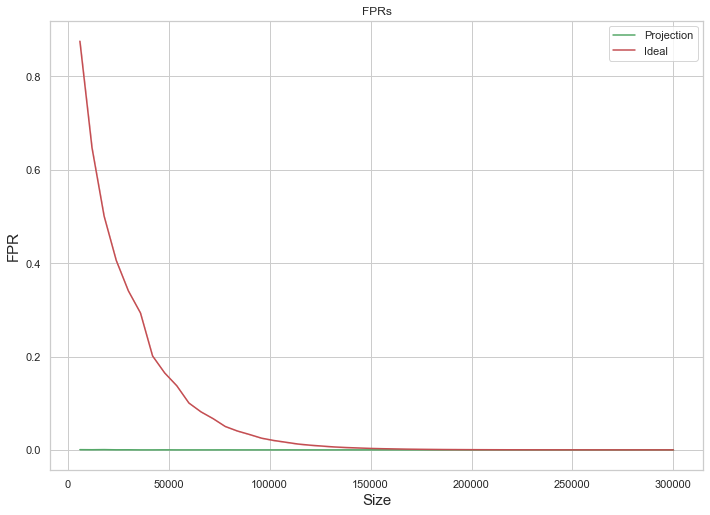

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [27]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

150


In [28]:
average_times = num_of_iterations*average_times
print(len(average_times))

150


In [29]:
print(average_fprs)

[0.00048, 0.00032, 0.0005866666666666667, 0.00016, 0.00021333333333333336, 0.0, 0.0, 0.00010666666666666668, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0002666666666666667, 0.0, 0.0, 0.00016, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010666666666666668, 0.00016, 0.00016, 0.0, 0.00048, 0.00032, 0.0005866666666666667, 0.00016, 0.00021333333333333336, 0.0, 0.0, 0.00010666666666666668, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 0.0, 0.0, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 5.333333333333334e-05, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0, 5.333333333333334e-05, 0.0002666666666666667, 0.0, 0.0, 0.00016, 5.333333333333334e-05, 5.

In [21]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1,0.066767,0.099651,0.08640,0.0194,6.079813,6.1600
1,20,1.0000,0.054560,0.077297,0.06832,0.0156,7.419567,6.4472
2,30,1,0.082914,0.083802,0.02208,0.0069,7.792258,8.2145
3,40,1.0000,0.203008,0.234041,0.02016,0.0058,4.548893,6.8539
4,50,1,0.052870,0.067674,0.00800,0.0036,4.167582,6.3462


In [22]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/2D_rerun_epochs_100.csv')